<h1 style="font-size:30px;">Deploying the ASL Classifier to Vitis-AI</h1>  

This notebook describes how to quantize and compile a TensorFlow2 model with Vitis-AI for deployment.

<img src='./images/VGG16_06_asl_fine_tuning.png' width=1000 align='center'><br/>

## Table of Contents
* [1 System Configuration](#1-System-Configuration)
* [2 Download and Extract the Dataset](#2-Download-and-Extract-the-Dataset)
* [3 Dataset Configuration](#3-Dataset-Configuration)
* [4 Quantization](#4-Quantization)
* [5 Compilation](#5-Compilation)
* [6 Conclusion](#6-Conclusion)


In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import random
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
import zipfile
import requests
import glob as glob

from tensorflow.keras.utils import image_dataset_from_directory

from matplotlib.ticker import (MultipleLocator, FormatStrFormatter)
from dataclasses import dataclass 

block_plot = False
plt.rcParams['figure.figsize'] = (12, 9)
SEED_VALUE = 42 

2023-05-08 08:22:15.575389: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-08 08:22:15.707838: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
print("tensorflow version : ",tf.__version__)
print("tensorflow version : ",keras.__version__)
print("opencv version : ",cv2.__version__)

tensorflow version :  2.10.0
tensorflow version :  2.10.0
opencv version :  4.6.0


## 1 System Configuration

In [3]:
def system_config():
    
    # Get list of GPUs.
    gpu_devices = tf.config.list_physical_devices('GPU')
    print(gpu_devices)
    
    if len(gpu_devices) > 0:
        print('Using GPU')
        os.environ["CUDA_VISIBLE_DEVICES"] = '0'
        os.environ['TF_CUDNN_DETERMINISTIC'] = '1' 
        
        # If there are any gpu devices, use first gpu.
        tf.config.experimental.set_visible_devices(gpu_devices[0], 'GPU')
        
        # Grow the memory usage as it is needed by the process.
        tf.config.experimental.set_memory_growth(gpu_devices[0], True)
        
        # Enable using cudNN.
        os.environ['TF_USE_CUDNN'] = "true"
    else:
        print('Using CPU')

system_config()

[]
Using CPU


## 2 Download and Extract the Dataset

In [4]:
def download_file(url, save_name):
    url = url
    file = requests.get(url)

    open(save_name, 'wb').write(file.content)

In [5]:
def unzip(zip_file=None):
    try:
        with zipfile.ZipFile(zip_file) as z:
            z.extractall("./")
            print("Extracted all")
    except:
        print("Invalid file")

In [6]:
#download_file(
#    'https://github.com/AlbertaBeef/asl_tutorial/releases/download/vitis_ai_3.0_version2/dataset_ASL_reduced.zip?dl=1', 
#    'dataset_ASL_reduced.zip'
#)
    
#unzip(zip_file='dataset_ASL_reduced.zip')

## 3 Dataset and Training Configuration

In [7]:
@dataclass(frozen=True)
class DatasetConfig:
    NUM_CLASSES: int = 29
    IMG_HEIGHT:  int = 224
    IMG_WIDTH:   int = 224
    CHANNELS:    int = 3
    BATCH_SIZE:  int = 32
    TRAINING_DATA_ROOT:   str = './dataset_ASL_reduced/training'
    VALIDATION_DATA_ROOT:   str = './dataset_ASL_reduced/validation'
        
@dataclass(frozen=True)
class TrainingConfig:
    BATCH_SIZE:     int   = 32
    EPOCHS:         int   = 51
    LEARNING_RATE:  float = 0.0005
    CHECKPOINT_DIR: str   = './saved_models_asl_classifier25'

### 3.1 Prepare the Training and Validation Dataset

In [8]:
train_dataset = image_dataset_from_directory(directory=DatasetConfig.TRAINING_DATA_ROOT,
                                             batch_size=TrainingConfig.BATCH_SIZE,
                                             shuffle=True,
                                             seed=SEED_VALUE,
                                             label_mode='categorical',
                                             image_size=(DatasetConfig.IMG_WIDTH, DatasetConfig.IMG_HEIGHT),
                                            )

valid_dataset = image_dataset_from_directory(directory=DatasetConfig.VALIDATION_DATA_ROOT,
                                             batch_size=TrainingConfig.BATCH_SIZE,
                                             shuffle=True,
                                             seed=SEED_VALUE,
                                             label_mode='categorical',
                                             image_size=(DatasetConfig.IMG_WIDTH, DatasetConfig.IMG_HEIGHT),
                                            )

Found 5800 files belonging to 29 classes.


2023-05-08 08:22:18.513367: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Found 1450 files belonging to 29 classes.


### 3.2 Normalizing the Datasets

reference : https://www.tensorflow.org/tutorials/load_data/images

In [9]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [10]:
normalized_train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))

In [11]:
normalized_valid_dataset = valid_dataset.map(lambda x, y: (normalization_layer(x), y))

## 4 Quantization

**Load model**

Load model for the rest of the tutorial with the `load_model` method.

In [12]:
model = keras.models.load_model('tf2_asl_classifier23.h5')
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 16  432         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 16  64          ['Conv1[0][0]']                  
                                )                                                             

 block_3_expand_relu (ReLU)     (None, 56, 56, 96)   0           ['block_3_expand_BN[0][0]']      
                                                                                                  
 block_3_pad (ZeroPadding2D)    (None, 57, 57, 96)   0           ['block_3_expand_relu[0][0]']    
                                                                                                  
 block_3_depthwise (DepthwiseCo  (None, 28, 28, 96)  864         ['block_3_pad[0][0]']            
 nv2D)                                                                                            
                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 28, 28, 96)  384         ['block_3_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_3_d

 lization)                                                                                        
                                                                                                  
 block_7_expand (Conv2D)        (None, 14, 14, 192)  6144        ['block_6_project_BN[0][0]']     
                                                                                                  
 block_7_expand_BN (BatchNormal  (None, 14, 14, 192)  768        ['block_7_expand[0][0]']         
 ization)                                                                                         
                                                                                                  
 block_7_expand_relu (ReLU)     (None, 14, 14, 192)  0           ['block_7_expand_BN[0][0]']      
                                                                                                  
 block_7_depthwise (DepthwiseCo  (None, 14, 14, 192)  1728       ['block_7_expand_relu[0][0]']    
 nv2D)    

                                                                                                  
 block_10_depthwise_relu (ReLU)  (None, 14, 14, 192)  0          ['block_10_depthwise_BN[0][0]']  
                                                                                                  
 block_10_project (Conv2D)      (None, 14, 14, 48)   9216        ['block_10_depthwise_relu[0][0]']
                                                                                                  
 block_10_project_BN (BatchNorm  (None, 14, 14, 48)  192         ['block_10_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_11_expand (Conv2D)       (None, 14, 14, 288)  13824       ['block_10_project_BN[0][0]']    
                                                                                                  
 block_11_

 block_14_depthwise (DepthwiseC  (None, 7, 7, 480)   4320        ['block_14_expand_relu[0][0]']   
 onv2D)                                                                                           
                                                                                                  
 block_14_depthwise_BN (BatchNo  (None, 7, 7, 480)   1920        ['block_14_depthwise[0][0]']     
 rmalization)                                                                                     
                                                                                                  
 block_14_depthwise_relu (ReLU)  (None, 7, 7, 480)   0           ['block_14_depthwise_BN[0][0]']  
                                                                                                  
 block_14_project (Conv2D)      (None, 7, 7, 80)     38400       ['block_14_depthwise_relu[0][0]']
                                                                                                  
 block_14_

In [13]:
print(f"Model evaluation accuracy (validation dataset): {model.evaluate(valid_dataset)[1]*100.:.3f}")

46/46 [==============================] - 11s 218ms/step - loss: 6.1518 - accuracy: 0.2379
Model evaluation accuracy (validation dataset): 23.793


In [14]:
print(f"Model evaluation accuracy (validation dataset): {model.evaluate(normalized_valid_dataset)[1]*100.:.3f}")

46/46 [==============================] - 10s 205ms/step - loss: 0.2320 - accuracy: 0.9441
Model evaluation accuracy (validation dataset): 94.414


In order to compile the trained model for deployment on a DPU platform, we must first quantize it. Here we will use the `vitis_quantize` module to convert the floating point model into an INT8 quantized representation. 

In [15]:
from tensorflow_model_optimization.quantization.keras import vitis_quantize

**Quantize model**

By default the `quantize_model` function converts the weights, activations and inputs into 8-bit wide numbers. We can specify different values and configurations using `weight_bit`, `activation_bit` and other parameters. 

In [16]:
quantizer = vitis_quantize.VitisQuantizer(model)

In [17]:
#quantized_model = quantizer.quantize_model(calib_dataset=valid_dataset, weight_bit=8, activation_bit=8)
quantized_model = quantizer.quantize_model(calib_dataset=normalized_valid_dataset, weight_bit=8, activation_bit=8)

[VAI INFO] Update activation_bit: 8
[VAI INFO] Update weight_bit: 8
[VAI INFO] Quantizing without specific `target`.
[VAI INFO] Start CrossLayerEqualization...
10/10 [==============================] - 10s 1s/step
[VAI INFO] CrossLayerEqualization Done.
[VAI INFO] Start Quantize Calibration...
46/46 [==============================] - 77s 995ms/step
[VAI INFO] Quantize Calibration Done.
[VAI INFO] Start Post-Quant Model Refinement...
[VAI INFO] Start Quantize Position Ajustment...
[VAI INFO] Quantize Position Ajustment Done.
[VAI INFO] Post-Quant Model Refninement Done.
[VAI INFO] Start Model Finalization...
[VAI INFO] Model Finalization Done.
[VAI INFO] Quantization Finished.


**Evaluate quantized model**

In order to evaluate the quantized model, it needs to be re-compiled with the desired loss and evaluation metrics, such as accuracy. Since we are using 8-bit quantization we do not lose much performance, if at all.

In [18]:
quantized_model.compile(loss='categorical_crossentropy', metrics=["accuracy"])

In [19]:
print(f"Model evaluation accuracy (validation dataset): {quantized_model.evaluate(valid_dataset)[1]*100.:.3f}")

46/46 [==============================] - 16s 177ms/step - loss: 11.6042 - accuracy: 0.0345
Model evaluation accuracy (validation dataset): 3.448


In [20]:
print(f"Model evaluation accuracy (validation dataset): {quantized_model.evaluate(normalized_valid_dataset)[1]*100.:.3f}")

46/46 [==============================] - 8s 177ms/step - loss: 1.7928 - accuracy: 0.5566
Model evaluation accuracy (validation dataset): 55.655


**Quantize Aware Training (QAT)**

In order to improve the accuracy of the quantized model, we need to apply fine-tuning with quantize-aware training (QAT).

In [21]:
qat_model = quantizer.get_qat_model()

[VAI INFO] Quantizing without specific `target`.
[VAI INFO] Start CrossLayerEqualization...
10/10 [==============================] - 10s 1s/step
[VAI INFO] CrossLayerEqualization Done.
[VAI INFO] Start Generation of Quantize-aware Training Model.
[VAI INFO] Generation of Quantize-aware Training Model Done.


In [22]:
qat_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=TrainingConfig.LEARNING_RATE),
                  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                  metrics=['accuracy'],
                 )

In [23]:
print(qat_model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 quant_input_2 (VitisQuantize)  (None, 224, 224, 3)  4           ['input_2[0][0]']                
                                                                                                  
 quant_Conv1 (QuantizeWrapper)  (None, 112, 112, 16  455         ['quant_input_2[0][0]']          
                                )                                                                 
                                                                                              

 quant_block_4_depthwise (Quant  (None, 28, 28, 96)  967         ['quant_block_4_expand_relu[0][0]
 izeWrapper)                                                     ']                               
                                                                                                  
 quant_block_4_depthwise_relu (  (None, 28, 28, 96)  4           ['quant_block_4_depthwise[0][0]']
 QuantizeWrapper)                                                                                 
                                                                                                  
 quant_block_4_project (Quantiz  (None, 28, 28, 16)  1562        ['quant_block_4_depthwise_relu[0]
 eWrapper)                                                       [0]']                            
                                                                                                  
 quant_block_4_add (QuantizeWra  (None, 28, 28, 16)  4           ['quant_block_3_project[0][0]',  
 pper)    

                                                                                                  
 quant_block_9_expand (Quantize  (None, 14, 14, 192)  6343       ['quant_block_8_add[0][0]']      
 Wrapper)                                                                                         
                                                                                                  
 quant_block_9_expand_relu (Qua  (None, 14, 14, 192)  4          ['quant_block_9_expand[0][0]']   
 ntizeWrapper)                                                                                    
                                                                                                  
 quant_block_9_depthwise (Quant  (None, 14, 14, 192)  1927       ['quant_block_9_expand_relu[0][0]
 izeWrapper)                                                     ']                               
                                                                                                  
 quant_blo

 (QuantizeWrapper)                                               ]                                
                                                                                                  
 quant_block_13_project (Quanti  (None, 7, 7, 80)    23130       ['quant_block_13_depthwise_relu[0
 zeWrapper)                                                      ][0]']                           
                                                                                                  
 quant_block_14_expand (Quantiz  (None, 7, 7, 480)   38887       ['quant_block_13_project[0][0]'] 
 eWrapper)                                                                                        
                                                                                                  
 quant_block_14_expand_relu (Qu  (None, 7, 7, 480)   4           ['quant_block_14_expand[0][0]']  
 antizeWrapper)                                                                                   
          

In [24]:
# Save best model based on highest validation_accuracy.
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=TrainingConfig.CHECKPOINT_DIR,
                                                               save_weights_only=False,
                                                               monitor='val_accuracy',
                                                               mode='max',
                                                               save_best_only=True,
                                                              )

In [25]:
from datetime import datetime

# datetime object containing current date and time
timestamp1 = datetime.now()
print(timestamp1)

2023-05-08 08:25:39.244137


In [26]:
# Then run the training process with this qat_model to get the quantize finetuned model.
qat_results = qat_model.fit(normalized_train_dataset,#train_dataset,
              validation_data=normalized_valid_dataset,#valid_dataset,
              epochs=16,#TrainingConfig.EPOCHS,
              workers=4,
              use_multiprocessing=True, 
              callbacks=model_checkpoint_callback,
             )

Epoch 1/16
182/182 [==============================] - ETA: 0s - loss: 0.1131 - accuracy: 0.9710

INFO:tensorflow:Assets written to: ./saved_models_asl_classifier25/assets


INFO:tensorflow:Assets written to: ./saved_models_asl_classifier25/assets


182/182 [==============================] - 458s 2s/step - loss: 0.1131 - accuracy: 0.9710 - val_loss: 0.0468 - val_accuracy: 0.9848
Epoch 2/16
182/182 [==============================] - 216s 1s/step - loss: 0.0559 - accuracy: 0.9833 - val_loss: 0.3381 - val_accuracy: 0.8993
Epoch 3/16
182/182 [==============================] - ETA: 0s - loss: 0.0422 - accuracy: 0.9876

INFO:tensorflow:Assets written to: ./saved_models_asl_classifier25/assets


INFO:tensorflow:Assets written to: ./saved_models_asl_classifier25/assets


182/182 [==============================] - 410s 2s/step - loss: 0.0422 - accuracy: 0.9876 - val_loss: 0.0232 - val_accuracy: 0.9924
Epoch 4/16
182/182 [==============================] - 217s 1s/step - loss: 0.0797 - accuracy: 0.9798 - val_loss: 0.2162 - val_accuracy: 0.9407
Epoch 5/16
182/182 [==============================] - 217s 1s/step - loss: 0.1105 - accuracy: 0.9655 - val_loss: 0.0595 - val_accuracy: 0.9848
Epoch 6/16
182/182 [==============================] - 217s 1s/step - loss: 0.0155 - accuracy: 0.9953 - val_loss: 0.0600 - val_accuracy: 0.9834
Epoch 7/16
182/182 [==============================] - 216s 1s/step - loss: 0.0495 - accuracy: 0.9841 - val_loss: 0.0700 - val_accuracy: 0.9807
Epoch 8/16
182/182 [==============================] - ETA: 0s - loss: 0.0188 - accuracy: 0.9947

182/182 [==============================] - 398s 2s/step - loss: 0.0188 - accuracy: 0.9947 - val_loss: 0.0229 - val_accuracy: 0.9931
Epoch 9/16
182/182 [==============================] - ETA: 0s - loss: 0.0026 - accuracy: 0.9993

INFO:tensorflow:Assets written to: ./saved_models_asl_classifier25/assets


INFO:tensorflow:Assets written to: ./saved_models_asl_classifier25/assets


182/182 [==============================] - 399s 2s/step - loss: 0.0026 - accuracy: 0.9993 - val_loss: 0.0254 - val_accuracy: 0.9938
Epoch 10/16
182/182 [==============================] - ETA: 0s - loss: 1.4438e-04 - accuracy: 1.0000

INFO:tensorflow:Assets written to: ./saved_models_asl_classifier25/assets


INFO:tensorflow:Assets written to: ./saved_models_asl_classifier25/assets


182/182 [==============================] - 399s 2s/step - loss: 1.4438e-04 - accuracy: 1.0000 - val_loss: 0.0171 - val_accuracy: 0.9952
Epoch 11/16
182/182 [==============================] - 216s 1s/step - loss: 7.5498e-05 - accuracy: 1.0000 - val_loss: 0.0165 - val_accuracy: 0.9945
Epoch 12/16
182/182 [==============================] - 216s 1s/step - loss: 4.6995e-05 - accuracy: 1.0000 - val_loss: 0.0148 - val_accuracy: 0.9952
Epoch 13/16
182/182 [==============================] - 216s 1s/step - loss: 3.5818e-05 - accuracy: 1.0000 - val_loss: 0.0157 - val_accuracy: 0.9952
Epoch 14/16
182/182 [==============================] - 216s 1s/step - loss: 2.8991e-05 - accuracy: 1.0000 - val_loss: 0.0147 - val_accuracy: 0.9952
Epoch 15/16
182/182 [==============================] - 217s 1s/step - loss: 2.4469e-05 - accuracy: 1.0000 - val_loss: 0.0141 - val_accuracy: 0.9952
Epoch 16/16
182/182 [==============================] - 216s 1s/step - loss: 2.0376e-05 - accuracy: 1.0000 - val_loss: 0.0146

In [27]:
timestamp2 = datetime.now()
print(timestamp2)

print(timestamp2-timestamp1)

2023-05-08 09:39:45.085975
1:14:05.841838


In [28]:
def plot_results(metrics, ylabel=None, ylim=None, metric_name=None, color=None):
    
    fig, ax = plt.subplots(figsize=(15, 4))

    if not (isinstance(metric_name, list) or isinstance(metric_name, tuple)):
        metrics = [metrics,]
        metric_name = [metric_name,]
        
    for idx, metric in enumerate(metrics):    
        ax.plot(metric, color=color[idx])
    
    plt.xlabel("Epoch")
    plt.ylabel(ylabel)
    plt.title(ylabel)
    plt.xlim([0, TrainingConfig.EPOCHS-1])
    plt.ylim(ylim)
    # Tailor x-axis tick marks
    ax.xaxis.set_major_locator(MultipleLocator(5))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
    ax.xaxis.set_minor_locator(MultipleLocator(1))
    plt.grid(True)
    plt.legend(metric_name)   
    plt.show(block=block_plot)
    plt.close()

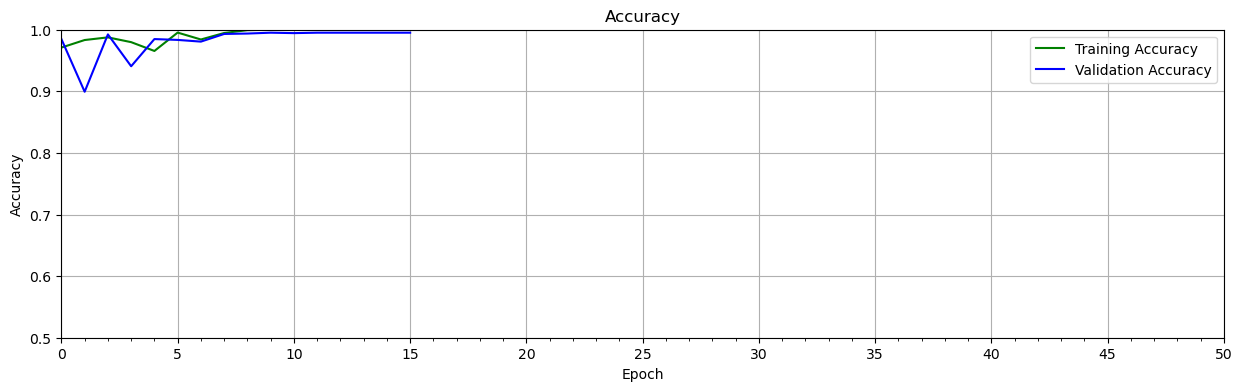

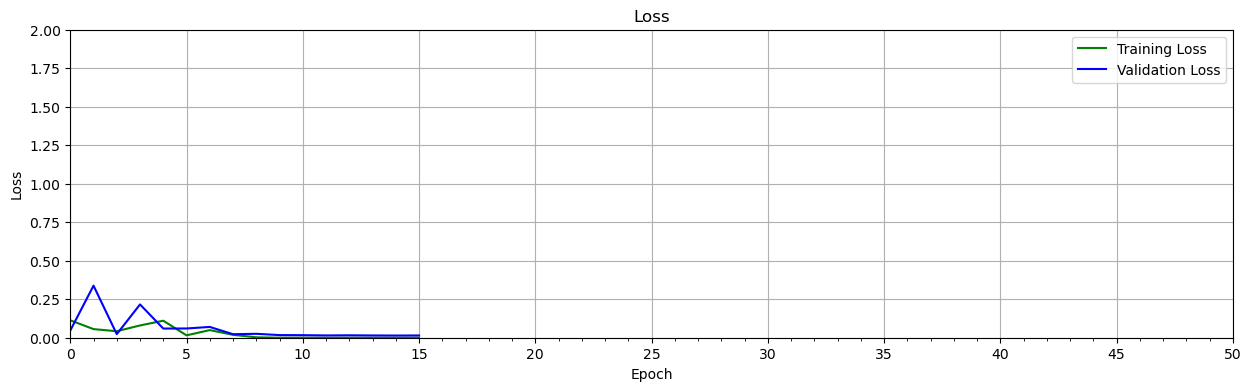

In [29]:
# Retrieve training results.
train_loss = qat_results.history["loss"]
train_acc  = qat_results.history["accuracy"]
valid_loss = qat_results.history["val_loss"]
valid_acc  = qat_results.history["val_accuracy"]
    
plot_results([ train_acc, valid_acc ], 
            ylabel="Accuracy",
            ylim = [0.5, 1.0],
            metric_name=["Training Accuracy", "Validation Accuracy"],
            color=["g", "b"])
 
max_loss = 2.0

plot_results([ train_loss, valid_loss ],        
            ylabel="Loss", 
            ylim = [0.0, max_loss],
            metric_name=["Training Loss", "Validation Loss"],
            color=["g", "b"]);

**Evaluate quantized model**

In order to evaluate the quantized model, it needs to be re-compiled with the desired loss and evaluation metrics, such as accuracy. Since we are using 8-bit quantization we do not lose much performance, if at all.

In [30]:
qat_model.compile(loss='categorical_crossentropy', metrics=["accuracy"])

In [31]:
print(f"Model evaluation accuracy (training dataset): {qat_model.evaluate(train_dataset)[1]*100.:.3f}")

182/182 [==============================] - 39s 178ms/step - loss: 11.7582 - accuracy: 0.0345
Model evaluation accuracy (training dataset): 3.448


In [32]:
print(f"Model evaluation accuracy (training dataset): {qat_model.evaluate(normalized_train_dataset)[1]*100.:.3f}")

182/182 [==============================] - 33s 178ms/step - loss: 1.8492e-05 - accuracy: 1.0000
Model evaluation accuracy (training dataset): 100.000


In [33]:
print(f"Model evaluation accuracy (validation dataset): {qat_model.evaluate(valid_dataset)[1]*100.:.3f}")

46/46 [==============================] - 8s 176ms/step - loss: 11.7566 - accuracy: 0.0345
Model evaluation accuracy (validation dataset): 3.448


In [34]:
print(f"Model evaluation accuracy (validation dataset): {qat_model.evaluate(normalized_valid_dataset)[1]*100.:.3f}")

46/46 [==============================] - 8s 175ms/step - loss: 0.0146 - accuracy: 0.9952
Model evaluation accuracy (validation dataset): 99.517


**Save quantized model**

Once we are happy with the performance of the quantized model, we can save it as a .h5 file, simply using the `save` method.

In [35]:
#quantized_model.save('tf2_asl_classifier25_quantized.h5')
qat_model.save('tf2_asl_classifier25_quantized.h5')

## 5 Compilation

For this final step we use the Vitis AI compiler `vai_c_tensorflow2` and pass the quantized model as a parameter. 

The target platform (ie. specific DPU architecture) is defined by .arch file.

To support as many platforms as possible, we compile for the following DPU architectures:
- B4096 (ZCU102, ZCU104, UltraZed-EV)
- B3136 (KV260)
- B2304 (Ultra96-V2)
- B1152 (Ultra96-V2+DualCam)
-  B512 (ZUBoard)
-  B128 (ZUBoard+DualCam)

In [36]:
!vai_c_tensorflow2 \
    --model ./tf2_asl_classifier25_quantized.h5 \
    --arch ./arch/B4096/arch-zcu104.json \
    --output_dir ./model_mobilenetv2/B4096/ \
    --net_name asl_classifier

!vai_c_tensorflow2 \
    --model ./tf2_asl_classifier25_quantized.h5 \
    --arch ./arch/B3136/arch-kv260.json \
    --output_dir ./model_mobilenetv2/B3136/ \
    --net_name asl_classifier

!vai_c_tensorflow2 \
    --model ./tf2_asl_classifier25_quantized.h5 \
    --arch ./arch/B2304/arch-b2304-lr.json \
    --output_dir ./model_mobilenetv2/B2304/ \
    --net_name asl_classifier

!vai_c_tensorflow2 \
    --model ./tf2_asl_classifier25_quantized.h5 \
    --arch ./arch/B1152/arch-b1152-hr.json \
    --output_dir ./model_mobilenetv2/B1152/ \
    --net_name asl_classifier

!vai_c_tensorflow2 \
    --model ./tf2_asl_classifier25_quantized.h5 \
    --arch ./arch/B512/arch-b512-lr.json \
    --output_dir ./model_mobilenetv2/B512/ \
    --net_name asl_classifier

!vai_c_tensorflow2 \
    --model ./tf2_asl_classifier25_quantized.h5 \
    --arch ./arch/B128/arch-b128-lr.json \
    --output_dir ./model_mobilenetv2/B128/ \
    --net_name asl_classifier


**************************************************
* VITIS_AI Compilation - Xilinx Inc.
**************************************************
[INFO] Namespace(batchsize=1, inputs_shape=None, layout='NHWC', model_files=['./tf2_asl_classifier25_quantized.h5'], model_type='tensorflow2', named_inputs_shape=None, out_filename='/tmp/asl_classifier_DPUCZDX8G_ISA1_B4096_org.xmodel', proto=None)
[INFO] tensorflow2 model: /workspace/tf2_asl_classifier25_quantized.h5
[INFO] keras version: 2.10.0
[INFO] Tensorflow Keras model type: functional
[INFO] generate xmodel     :100%|█| 174/174 [00:00<00:00, 2757.96it/s]          
[INFO] dump xmodel: /tmp/asl_classifier_DPUCZDX8G_ISA1_B4096_org.xmodel
[UNILOG][INFO] Compile mode: dpu
[UNILOG][INFO] Debug mode: null
[UNILOG][INFO] Target architecture: DPUCZDX8G_ISA1_B4096
[UNILOG][INFO] Graph name: model, with op num: 384
[UNILOG][INFO] Begin to compile...
[UNILOG][INFO] Total device subgraph number 3, DPU subgraph number 1
[UNILOG][INFO] Compile done.
[UNILOG

[UNILOG][INFO] Total device subgraph number 3, DPU subgraph number 1
[UNILOG][INFO] Compile done.
[UNILOG][INFO] The meta json is saved to "/workspace/./model_mobilenetv2/B512/meta.json"
[UNILOG][INFO] The compiled xmodel is saved to "/workspace/./model_mobilenetv2/B512//asl_classifier.xmodel"
[UNILOG][INFO] The compiled xmodel's md5sum is 70d4a43a51d384f2e4a2d050b4f1acb6, and has been saved to "/workspace/./model_mobilenetv2/B512/md5sum.txt"
**************************************************
* VITIS_AI Compilation - Xilinx Inc.
**************************************************
[INFO] Namespace(batchsize=1, inputs_shape=None, layout='NHWC', model_files=['./tf2_asl_classifier25_quantized.h5'], model_type='tensorflow2', named_inputs_shape=None, out_filename='/tmp/asl_classifier_0x101000002010208_org.xmodel', proto=None)
[INFO] tensorflow2 model: /workspace/tf2_asl_classifier25_quantized.h5
[INFO] keras version: 2.10.0
[INFO] Tensorflow Keras model type: functional
[INFO] generate xmodel

## 6 Conclusion

In this notebook, we showed how to quantize and compile a TensorFlow2 model with Vitis-AI for deployment on AMD Zynq-UltraScale+ devices. 